Original: 462.73 KB, Compressed: 24.50 KB, Ratio: 18.89x


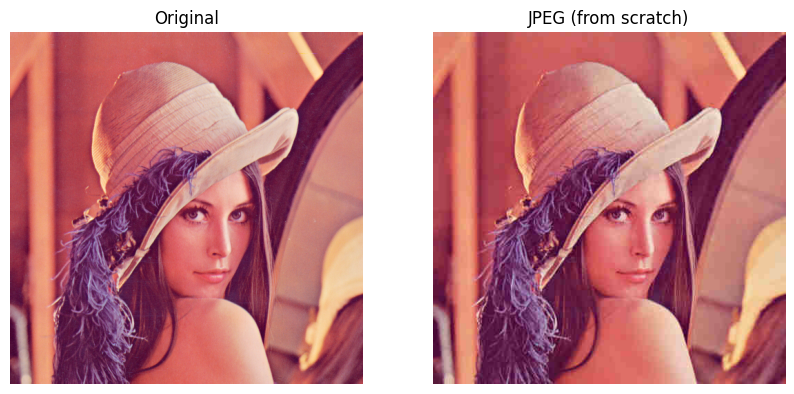

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from scipy.fftpack import dct, idct

# =============================
# JPEG COMPRESSION FROM SCRATCH
# =============================

# Standard JPEG quantization matrix for luminance
QY = np.array([
    [16,11,10,16,24,40,51,61],
    [12,12,14,19,26,58,60,55],
    [14,13,16,24,40,57,69,56],
    [14,17,22,29,51,87,80,62],
    [18,22,37,56,68,109,103,77],
    [24,35,55,64,81,104,113,92],
    [49,64,78,87,103,121,120,101],
    [72,92,95,98,112,100,103,99]
])

# Standard JPEG quantization matrix for chrominance
QC = np.array([
    [17,18,24,47,99,99,99,99],
    [18,21,26,66,99,99,99,99],
    [24,26,56,99,99,99,99,99],
    [47,66,99,99,99,99,99,99],
    [99,99,99,99,99,99,99,99],
    [99,99,99,99,99,99,99,99],
    [99,99,99,99,99,99,99,99],
    [99,99,99,99,99,99,99,99]
])

def rgb_to_ycbcr(img):
    """Convert RGB image to YCbCr"""
    xform = np.array([[0.299, 0.587, 0.114],
                      [-0.1687, -0.3313, 0.5],
                      [0.5, -0.4187, -0.0813]])
    ycbcr = img.dot(xform.T)
    ycbcr[:,:,1:] += 128
    return ycbcr

def ycbcr_to_rgb(img):
    """Convert YCbCr image to RGB"""
    xform = np.array([[1, 0, 1.402],
                      [1, -0.34414, -0.71414],
                      [1, 1.772, 0]])
    rgb = img.copy()
    rgb[:,:,1:] -= 128
    rgb = rgb.dot(xform.T)
    return np.clip(rgb, 0, 255)

def block_split(channel, block_size=8):
    """Split channel into non-overlapping 8x8 blocks"""
    h, w = channel.shape
    return (channel.reshape(h//block_size, block_size, -1, block_size)
                  .swapaxes(1,2)
                  .reshape(-1, block_size, block_size))

def block_merge(blocks, h, w, block_size=8):
    """Merge blocks back into image"""
    blocks = blocks.reshape(h//block_size, w//block_size, block_size, block_size)
    blocks = blocks.swapaxes(1,2).reshape(h,w)
    return blocks

def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct2(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

def quantize(block, qmatrix):
    return np.round(block / qmatrix)

def dequantize(block, qmatrix):
    return block * qmatrix

# =============================
# MAIN JPEG PIPELINE
# =============================
def jpeg_compress(img, quality=50):
    """Compress an image using simplified JPEG steps"""

    # Convert to YCbCr
    ycbcr = rgb_to_ycbcr(img).astype(np.float32)
    Y, Cb, Cr = [ycbcr[:,:,i] for i in range(3)]

    h, w = Y.shape

    # Adjust quantization based on quality
    scale = 50/quality if quality < 50 else (100-quality)/50
    QYq = np.clip(QY * (1+scale), 1, 255)
    QCq = np.clip(QC * (1+scale), 1, 255)

    channels = [Y, Cb, Cr]
    qtables = [QYq, QCq, QCq]
    compressed_blocks = []

    for idx, (ch, qt) in enumerate(zip(channels, qtables)):
        # Pad image to multiple of 8
        pad_h = (8 - ch.shape[0]%8) % 8
        pad_w = (8 - ch.shape[1]%8) % 8
        ch_padded = np.pad(ch, ((0,pad_h),(0,pad_w)), mode='constant', constant_values=0)

        # Split into 8x8 blocks
        blocks = block_split(ch_padded)

        # DCT + Quantization
        blocks_dct = [dct2(b-128) for b in blocks]
        blocks_q = [quantize(b, qt) for b in blocks_dct]

        compressed_blocks.append((blocks_q, ch_padded.shape))

    return compressed_blocks, (h,w), qtables


def jpeg_decompress(compressed_blocks, shape, qtables):
    """Decompress JPEG blocks back into image"""
    h, w = shape
    channels = []
    for (blocks_q, padded_shape), qt in zip(compressed_blocks, qtables):
        # Dequantize + IDCT
        blocks_deq = [dequantize(b, qt) for b in blocks_q]
        blocks_idct = [idct2(b)+128 for b in blocks_deq]

        # Merge blocks
        ch = block_merge(np.array(blocks_idct), padded_shape[0], padded_shape[1])
        channels.append(ch[:h,:w])

    ycbcr = np.stack(channels, axis=2)
    rgb = ycbcr_to_rgb(ycbcr)
    return rgb.astype(np.uint8)

# =============================
# DEMO
# =============================
if __name__ == "__main__":
    # Load input
    input_path = "Lenna.png"   # put your file
    img = np.array(Image.open(input_path).convert("RGB"))

    # Compress
    compressed_blocks, shape, qtables = jpeg_compress(img, quality=30)

    # Decompress
    recon = jpeg_decompress(compressed_blocks, shape, qtables)

    # Save output
    output_path = "output_from_scratch.jpg"
    Image.fromarray(recon).save(output_path)

    # Sizes
    orig_size = os.path.getsize(input_path)/1024
    comp_size = os.path.getsize(output_path)/1024
    print(f"Original: {orig_size:.2f} KB, Compressed: {comp_size:.2f} KB, Ratio: {orig_size/comp_size:.2f}x")

    # Show
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].imshow(img)
    ax[0].set_title("Original")
    ax[0].axis("off")

    ax[1].imshow(recon)
    ax[1].set_title("JPEG (from scratch)")
    ax[1].axis("off")
    plt.show()
